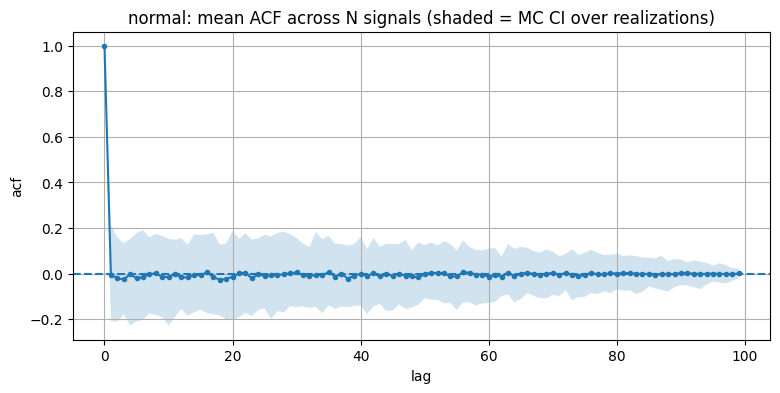

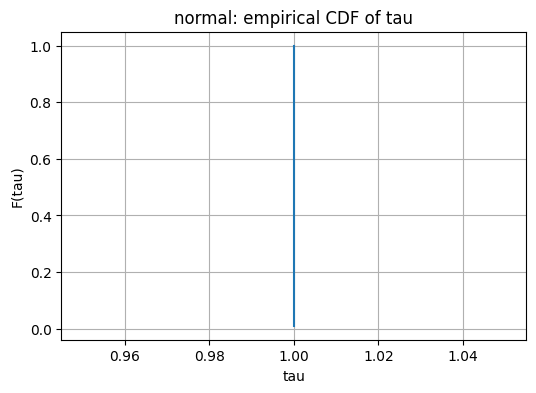

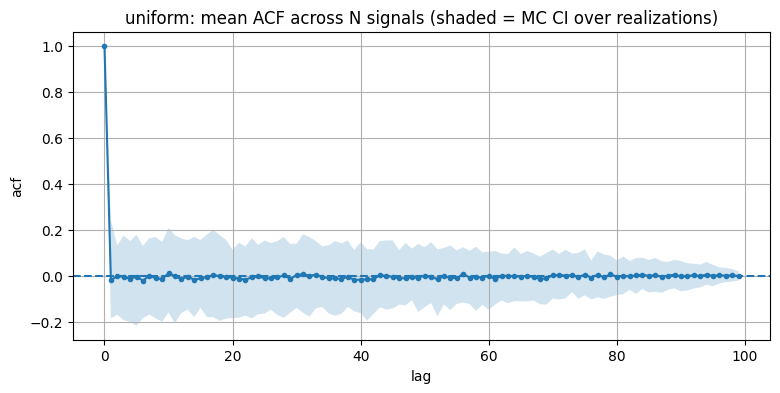

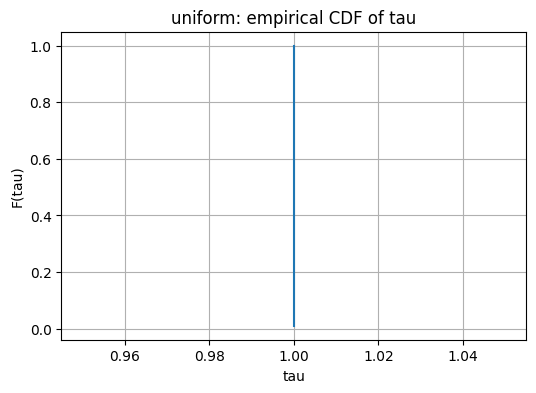

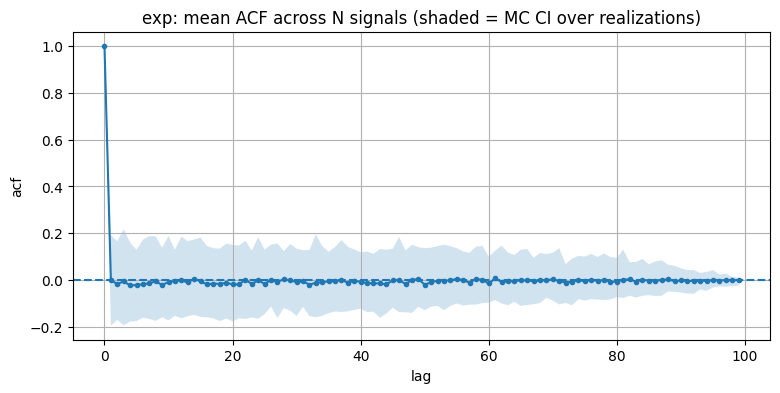

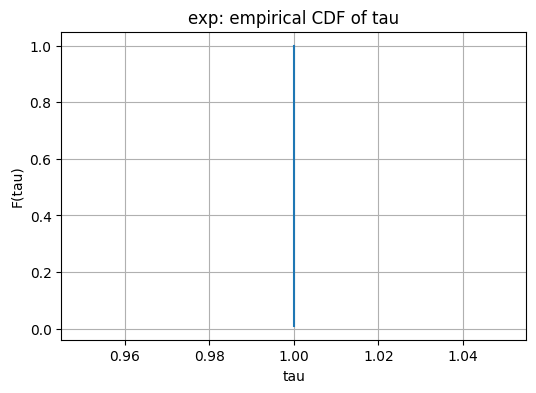

Summary tau (mean, median, 0.9-quantile):
normal 1.0 1.0 1.0
uniform 1.0 1.0 1.0
exp 1.0 1.0 1.0


In [1]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(42)

N = 10**2
n = 100
max_lag = n - 1

Q = 0.95
alpha = 1 - Q
z = 1.96
meas_eps = 0.2

dists = ["normal", "uniform", "exp"]

def gen_white_noise(dist, size):
    if dist == "normal":
        x = rng.normal(0.0, 1.0, size=size)
    elif dist == "uniform":
        x = rng.uniform(-np.sqrt(3.0), np.sqrt(3.0), size=size)
    elif dist == "exp":
        x = rng.exponential(1.0, size=size) - 1.0
    else:
        raise ValueError("unknown dist")
    return x

def standardize(x):
    x = np.asarray(x)
    return (x - x.mean()) / x.std(ddof=0)

def add_measurement_error(x, eps=0.2):
    return x + rng.uniform(-eps, eps, size=len(x))

def acf(x, max_lag):
    x = np.asarray(x)
    x = x - x.mean()
    denom = np.dot(x, x)
    if denom == 0:
        return np.zeros(max_lag + 1)
    out = np.empty(max_lag + 1)
    out[0] = 1.0
    for k in range(1, max_lag + 1):
        out[k] = np.dot(x[:-k], x[k:]) / denom
    return out

def bootstrap_acf_ci(x, max_lag, B=300):
    x = np.asarray(x)
    n = len(x)
    acfs = np.empty((B, max_lag + 1))
    for b in range(B):
        idx = rng.integers(0, n, size=n)
        xb = x[idx]
        acfs[b] = acf(xb, max_lag)
    lo = np.quantile(acfs, alpha/2, axis=0)
    hi = np.quantile(acfs, 1 - alpha/2, axis=0)
    return lo, hi

def tau_from_ci(ci_lo, ci_hi):
    max_lag = len(ci_lo) - 1
    sig = np.array([(not (ci_lo[k] <= 0.0 <= ci_hi[k])) for k in range(max_lag + 1)])
    sig[0] = False
    for k in range(1, max_lag + 1):
        if not np.any(sig[k:]):
            return k
    return max_lag

B = 300

results = {}

for dist in dists:
    signals = []
    acf_list = []
    ci_lo_list = []
    ci_hi_list = []
    taus = []

    for _ in range(N):
        x = gen_white_noise(dist, n)
        x = standardize(x)
        x = add_measurement_error(x, meas_eps)

        signals.append(x)

        r = acf(x, max_lag)
        lo, hi = bootstrap_acf_ci(x, max_lag, B=B)

        acf_list.append(r)
        ci_lo_list.append(lo)
        ci_hi_list.append(hi)
        taus.append(tau_from_ci(lo, hi))

    signals = np.array(signals)
    acf_list = np.array(acf_list)
    ci_lo_list = np.array(ci_lo_list)
    ci_hi_list = np.array(ci_hi_list)
    taus = np.array(taus)

    mean_acf = acf_list.mean(axis=0)
    ci_lo_mean = np.quantile(acf_list, alpha/2, axis=0)
    ci_hi_mean = np.quantile(acf_list, 1 - alpha/2, axis=0)

    results[dist] = {
        "signals": signals,
        "acf": acf_list,
        "ci_lo": ci_lo_list,
        "ci_hi": ci_hi_list,
        "tau": taus,
        "mean_acf": mean_acf,
        "ci_lo_mean": ci_lo_mean,
        "ci_hi_mean": ci_hi_mean,
    }

    lags = np.arange(max_lag + 1)

    plt.figure(figsize=(9, 4))
    plt.plot(lags, mean_acf, marker="o", markersize=3)
    plt.fill_between(lags, ci_lo_mean, ci_hi_mean, alpha=0.2)
    plt.axhline(0.0, linestyle="--")
    plt.title(dist + ": mean ACF across N signals (shaded = MC CI over realizations)")
    plt.xlabel("lag")
    plt.ylabel("acf")
    plt.grid(True)
    plt.show()

    tau_sorted = np.sort(taus)
    y = np.arange(1, len(tau_sorted) + 1) / len(tau_sorted)
    plt.figure(figsize=(6, 4))
    plt.step(tau_sorted, y, where="post")
    plt.title(dist + ": empirical CDF of tau")
    plt.xlabel("tau")
    plt.ylabel("F(tau)")
    plt.grid(True)
    plt.show()

print("Summary tau (mean, median, 0.9-quantile):")
for dist in dists:
    taus = results[dist]["tau"]
    print(dist, float(np.mean(taus)), float(np.median(taus)), float(np.quantile(taus, 0.9)))

Домашнее задание

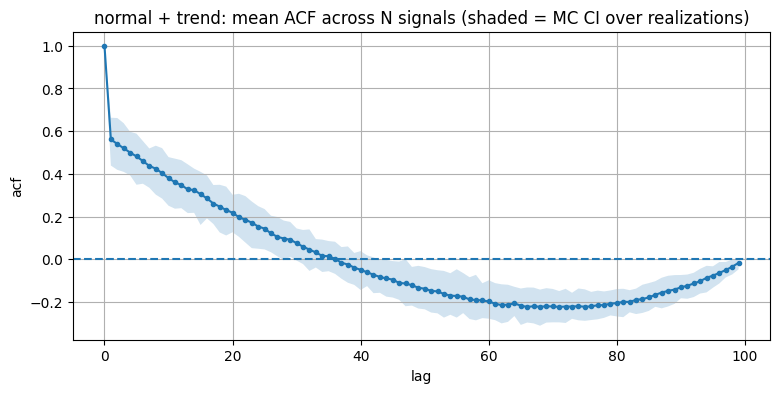

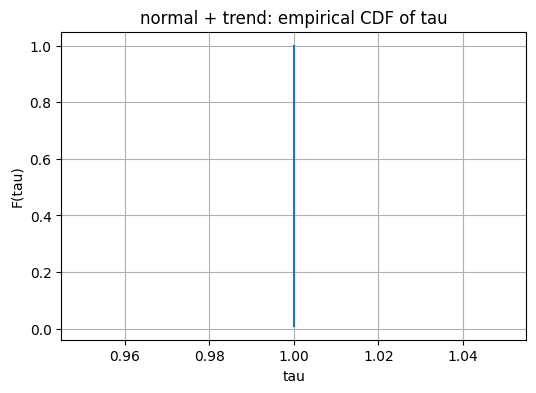

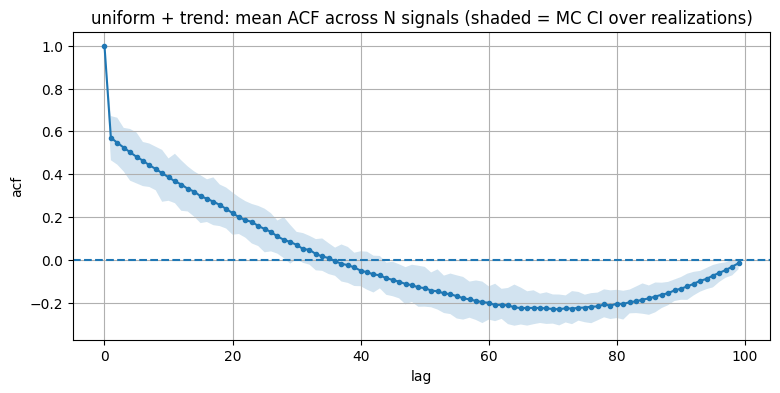

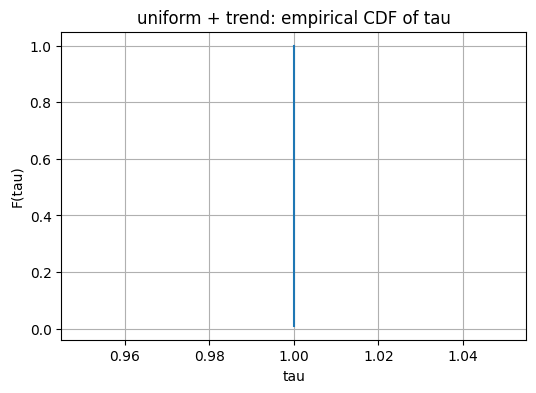

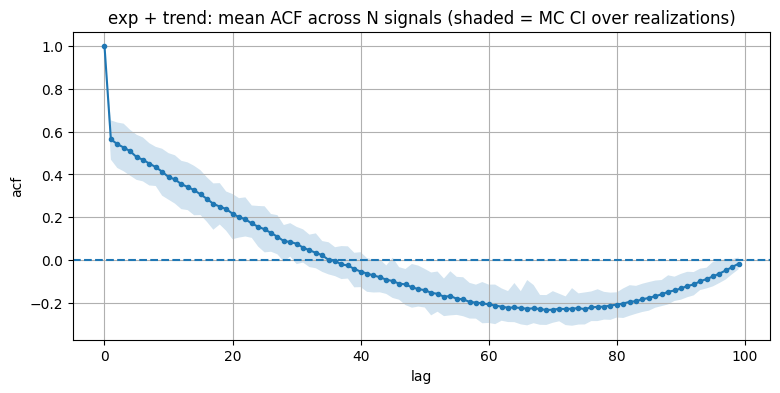

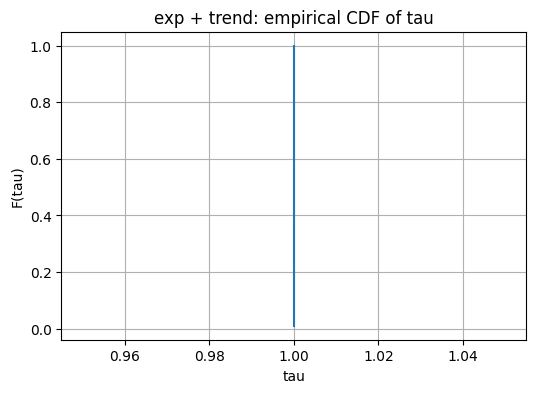

HW summary tau (mean, median, 0.9-quantile):
normal 1.0 1.0 1.0
uniform 1.0 1.0 1.0
exp 1.0 1.0 1.0


In [2]:
N = 10**2
n = 100
max_lag = n - 1
B = 300
meas_eps = 0.2

t_idx = np.arange(n)
trend = 5.0 * np.exp(-2.0 * t_idx / n)

results_hw = {}

for dist in dists:
    acf_list = []
    taus = []

    for _ in range(N):
        noise = gen_white_noise(dist, n)
        noise = standardize(noise)
        x = trend + noise
        x = add_measurement_error(x, meas_eps)
        r = acf(x, max_lag)
        lo, hi = bootstrap_acf_ci(x, max_lag, B=B)
        acf_list.append(r)
        taus.append(tau_from_ci(lo, hi))

    acf_list = np.array(acf_list)
    taus = np.array(taus)

    mean_acf = acf_list.mean(axis=0)
    ci_lo_mean = np.quantile(acf_list, alpha/2, axis=0)
    ci_hi_mean = np.quantile(acf_list, 1 - alpha/2, axis=0)

    results_hw[dist] = {"acf": acf_list, "tau": taus}

    lags = np.arange(max_lag + 1)

    plt.figure(figsize=(9, 4))
    plt.plot(lags, mean_acf, marker="o", markersize=3)
    plt.fill_between(lags, ci_lo_mean, ci_hi_mean, alpha=0.2)
    plt.axhline(0.0, linestyle="--")
    plt.title(dist + " + trend: mean ACF across N signals (shaded = MC CI over realizations)")
    plt.xlabel("lag")
    plt.ylabel("acf")
    plt.grid(True)
    plt.show()

    tau_sorted = np.sort(taus)
    y = np.arange(1, len(tau_sorted) + 1) / len(tau_sorted)
    plt.figure(figsize=(6, 4))
    plt.step(tau_sorted, y, where="post")
    plt.title(dist + " + trend: empirical CDF of tau")
    plt.xlabel("tau")
    plt.ylabel("F(tau)")
    plt.grid(True)
    plt.show()

print("HW summary tau (mean, median, 0.9-quantile):")
for dist in dists:
    taus = results_hw[dist]["tau"]
    print(dist, float(np.mean(taus)), float(np.median(taus)), float(np.quantile(taus, 0.9)))

Наличие тренда полностью доминирует над шумом и делает автокорреляцию значимой на всех лагах, из-за чего тау всегда равно 1.